# Elife Binary Random Forest Results

Andrew E. Davidson  
aedaivds@ucsc.edu 04/11/24  

Copyright (c) 2020-2023, Regents of the University of California All rights reserved. https://polyformproject.org/licenses/noncommercial/1.0.0

feature importance plots based on  Gini Impurity. Gini impurity is a measure of how often a randomly chosen element from the set would be incorrectly labeled if it was randomly labeled according to the distribution of labels in the subset. Impurity increases with randomness. We want features with less impurity.

**<span style="color:red;background-color:yellow">BUG plot titles assume all models are GTEx biomarkers</span>**  

**<span style="color:red;background-color:yellow">TODO</span>**  
1) change xticks labels on feature importance plots to HUGO. This makes it easier to identify repeats TEs, ... Make this a configurable option

**summary results for best hyperparmeter search results**   
elife samples are plasma extracelluar RNA gene expressions

For each of the 5 elife cancer types several biomarker sets where tried. The best of each set are plotted bellow


```
$ pwd
/private/groups/kimlab/aedavids/elife/hyperparmeterTunning

$ ls *{COAD,Colon,READ}*/*log | tee colorectal.logs.txt
$ ls *{COAD,Colon,READ}*/*csv | tee colorectal.csvs.txt

$ls *csvs.txt
colorectal.csvs.txt  esophagus.csvs.txt  liver.csvs.txt  lung.csvs.txt  stomach.csvs.txt

$ head -n 2 `cat esophagus.csvs.txt ` | cut -d , -f 3,5,7
==> randomForestHyperparmeterEsophagus_ESCASearch.sh.out/randomForestHyperparmeterSearch.csv <==
sensitivity_mean,specificity_mean,auc_mean
0.7861111111111111,0.4238095238095238,0.6049603174603175

==> randomForestHyperparmeterEsophagus_Gastroesophageal_JunctionSearch.sh.out/randomForestHyperparmeterSearch.csv <==
sensitivity_mean,specificity_mean,auc_mean
0.9777777777777779,0.06666666666666667,0.5222222222222221

==> randomForestHyperparmeterEsophagus_MucosaSearch.sh.out/randomForestHyperparmeterSearch.allFloats.csv <==
sensitivity_mean,specificity_mean,auc_mean
0.7861111111111111,0.5142857142857143,0.6501984126984126

==> randomForestHyperparmeterEsophagus_MucosaSearch.sh.out/randomForestHyperparmeterSearch.csv <==
sensitivity_mean,specificity_mean,auc_mean
0.7888888888888889,0.5476190476190477,0.6682539682539683

==> randomForestHyperparmeterEsophagus_MucosaSearch.sh.out/randomForestHyperparmeterSearch.noAUC.csv <==
sensitivity_mean,specificity_mean,max_features
1.0,0.0,1.0

==> randomForestHyperparmeterEsophagus_MuscularisSearch.sh.out/randomForestHyperparmeterSearch.csv <==
sensitivity_mean,specificity_mean,auc_mean
0.6277777777777777,0.5714285714285715,0.5996031746031746

```

In [1]:
import ipynbname

# use display() to print an html version of a data frame
# useful if dataFrame output is not generated by last like of cell
from IPython.display import display

import joblib
import math
import numpy as np
import os
import pandas as pd
pd.set_option('display.max_rows', None)
import pprint as pp
import matplotlib.pyplot as plt

import scikitplot as skplt

from sklearn.ensemble        import RandomForestClassifier

from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.model_selection import RepeatedStratifiedKFold

import sys

notebookName = ipynbname.name()
notebookPath = ipynbname.path()
notebookDir = os.path.dirname(notebookPath)

#outDir = f'{notebookDir}/{notebookName}.out'
outDir = f'/private/groups/kimlab/aedavids/elife/{notebookName}.out'
os.makedirs(outDir, exist_ok=True)
print(f'outDir:\n{outDir}')

modelOutDir = os.path.join(outDir, "model")
os.makedirs(modelOutDir, exist_ok=True)
print(f'\nmodelOutDir ;\n{modelOutDir}')

# results of hyperparmeter search
hyperparameterOut = "/private/groups/kimlab/aedavids/elife/hyperparmeterTunning"

imgOut = f'{outDir}/img'
os.makedirs(imgOut, exist_ok=True)
print(f'\nimgOut :\n{imgOut}')

import logging
#loglevel = "INFO"
loglevel = "WARN"
# logFMT = "%(asctime)s %(levelname)s [thr:%(threadName)s %(name)s %(funcName)s() line:%(lineno)s] [%(message)s]"
logFMT = "%(asctime)s %(levelname)s %(name)s %(funcName)s() line:%(lineno)s] [%(message)s]"
logging.basicConfig(format=logFMT, level=loglevel)    
logger = logging.getLogger(notebookName)

meaningOfLife = 42

/data/tmp/ipykernel_3878048/1759678894.py:11: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


outDir:
/private/groups/kimlab/aedavids/elife/elifeBinaryRandomForestResults.out

modelOutDir ;
/private/groups/kimlab/aedavids/elife/elifeBinaryRandomForestResults.out/model

imgOut :
/private/groups/kimlab/aedavids/elife/elifeBinaryRandomForestResults.out/img


In [2]:
# setting the python path allows us to run python scripts from using
# the CLI. 
ORIG_PYTHONPATH = os.environ['PYTHONPATH']

deconvolutionModules = notebookPath.parent.joinpath("../../../deconvolutionAnalysis/python/")
print("deconvolutionModules: {}\n".format(deconvolutionModules))

PYTHONPATH = ORIG_PYTHONPATH + f':{deconvolutionModules}'
print("PYTHONPATH: {}\n".format(PYTHONPATH))

intraExtraRNA_POCModules=notebookPath.parent.joinpath("../../python/src")
print("intraExtraRNA_POCModules: {}\n".format(intraExtraRNA_POCModules))

PYTHONPATH = PYTHONPATH + f':{intraExtraRNA_POCModules}'
print("PYTHONPATH: {}\n".format(PYTHONPATH))

os.environ["PYTHONPATH"] = PYTHONPATH
PYTHONPATH = os.environ["PYTHONPATH"]
print("PYTHONPATH: {}\n".format(PYTHONPATH))

# to be able to import our local python files we need to set the sys.path
# https://stackoverflow.com/a/50155834
sys.path.append( str(deconvolutionModules) )
sys.path.append( str(intraExtraRNA_POCModules) )
print("\nsys.path:\n{}\n".format(sys.path))

deconvolutionModules: /private/home/aedavids/extraCellularRNA/intraExtraRNA_POC/jupyterNotebooks/elife/../../../deconvolutionAnalysis/python

PYTHONPATH: :/private/home/aedavids/extraCellularRNA/src:/private/home/aedavids/extraCellularRNA/intraExtraRNA_POC/jupyterNotebooks/elife/../../../deconvolutionAnalysis/python

intraExtraRNA_POCModules: /private/home/aedavids/extraCellularRNA/intraExtraRNA_POC/jupyterNotebooks/elife/../../python/src

PYTHONPATH: :/private/home/aedavids/extraCellularRNA/src:/private/home/aedavids/extraCellularRNA/intraExtraRNA_POC/jupyterNotebooks/elife/../../../deconvolutionAnalysis/python:/private/home/aedavids/extraCellularRNA/intraExtraRNA_POC/jupyterNotebooks/elife/../../python/src

PYTHONPATH: :/private/home/aedavids/extraCellularRNA/src:/private/home/aedavids/extraCellularRNA/intraExtraRNA_POC/jupyterNotebooks/elife/../../../deconvolutionAnalysis/python:/private/home/aedavids/extraCellularRNA/intraExtraRNA_POC/jupyterNotebooks/elife/../../python/src


sys.p

In [3]:
# import local 
from analysis.utilities import findFile
from analysis.utilities import saveDictionary
from analysis.utilities import saveList
from intraExtraRNA.elifeUtilities import loadElifeTrainingData
from models.mlUtilities import encoder2Dict
from models.mlUtilities import saveLabelEncoder
# from models.randomForestHyperparmeterSearch import createScoringMetricsDict
# from models.randomForestHyperparmeterSearch import evaluateModel
# # from models.randomForestHyperparmeterSearch import tunningFramework
from models.plotROC import plotROC
from models.plotROC import plotROCWrapper
from pipeline.dataFactory.utilities import urlify

In [4]:
def plotFeatureImportance(
    panel : plt.axes,
    classifierModel,
    featureNames : list[str],
    title : str,
    xTickRotation : int = 45,
    textFontSize : str = "medium", # "small, medium  or large"
    order : str = None # "descending", # ascending', 'descending', or None, optional
    ) :
    '''
    ref: https://scikit-plot.readthedocs.io/en/stable/estimators.html#scikitplot.estimators.plot_feature_importances

    arguments 
            
        classifierModel:
            trained model 

        featureNames:
            must be in the same order as the columns of X we trained on

        xTickRotation 
            Rotates x-axis tick labels by the specified angle.
            
    '''
    skplt.estimators.plot_feature_importances(
        classifierModel, 
        feature_names=featureNames,
        title=title,
        #x_tick_rotation=xTickRotation,
        ax=panel,
        text_fontsize=textFontSize,
        order=order,
    )

    # the x_tick_rotation is messed up
    #plt.xticks(range(len(feature_importances)), np.array(feature_names)[sorted_indices], rotation=45, ha='right', rotation_mode='anchor')
    panel.set_xticks(range(len(featureNames)), featureNames,  
                     rotation=xTickRotation, ha='right', rotation_mode='anchor')

In [5]:
def runFeatureImportance(dataDict : dict,
                           cancerType,
                           setName : str, 
                           useHUGOImportanceFeatureNames : bool = True,
                          ):
    '''
    generates feature importance plot

    save plot and feature importance dictionary

    Note: the feature importance plot is not sorted. There is a bug in 
    skplt.estimators.plot_feature_importances. If order = ascending or descending 
    the labels are not asigned to the correct bar
    '''
    importanceTitle = f"elife {cancerType} Cancer random forest GTEx {setName} feature importance"
    importanceFig, importancePanel = plt.subplots(nrows=1, ncols=1, figsize=(4, 4), ) 

    # the importanceFeatureNames must exactly matches the order of features in your training dataset
    elifeGenes = dataDict['elifeGenes']
    if useHUGOImportanceFeatureNames :
        mapDF = dataDict['mapDF']
        tmpMapDF = mapDF.set_index('ENSG_v39')
        #print(f'MapDF:\n{tmpMapDF}')
        importanceFeatureNames = tmpMapDF.loc[elifeGenes, 'HUGO_v35'].to_list()
    else :
        importanceFeatureNames = elifeGenes
    print(f'\n importanceFeatureNames :\n{importanceFeatureNames}')

    
    randomForestModel = dataDict['model']    
    plotFeatureImportance(
        panel=importancePanel,
        classifierModel=randomForestModel,
        featureNames=importanceFeatureNames,
        title=importanceTitle,
        xTickRotation=45, #30, #15, #0, #45,
        textFontSize="medium",
        # if you order by something other than None, plot is mis labeled
        order=None, # 'descending' # None, ascending descending
    )  

    #
    # save plot
    #
    importanceFilePath = f'{imgOut}/{urlify(importanceTitle)}.png'
    importanceFig.savefig(importanceFilePath, dpi=600, bbox_inches='tight', facecolor="white", transparent=True)
    print(f'\nsaved importance plot to {importanceFilePath}')

    # save the feature importance score as a list of tuples sorted from most to least important
    # example : [('DZIP1', 0.1739446580843241), ('UBE2E2', 0.16044165231967855)
    importanceDict = dict(zip(importanceFeatureNames, randomForestModel.feature_importances_))
    dataDict['featureImportance'] = sorted(importanceDict.items(), key=lambda item: item[1], reverse=True)

    print(f'\n featureImportance:\n{dataDict["featureImportance"]}')

    #
    # save feature importance dictionar
    #
    rocTitle = dataDict['rocTitle']
    importanceDictPath = f'{modelOutDir}/{urlify(rocTitle)}_featureImportance.txt'
    saveDictionary( importanceDictPath, importanceDict)
    print(f'\nfeatureImportance saved to :\n {importanceDictPath}')

In [6]:
def driver(
    hyperParameterSearchResultsPath : str,    
    features : list[str] ,
    selectElifeCategories : list[str],
    pipelineStageName : str="best10CuratedDegree1_ce467ff",
    ):
    '''
    TOOD

    arguments:
        features:
            example ["Esophagus_Mucosa"]

        selectElifeCategories :
            example ["Healthy donor", "Esophagus Cancer"]
            
        hyperParameterSearchResultsPath:
            example
            d=/private/groups/kimlab/aedavids/elife/hyperparmeterTunning/
            ${d}/randomForestHyperparmeterEsophagus_MucosaSearch.sh.out/randomForestHyperparmeterSearch.csv
    '''

    retDict = dict()

    #
    # load training data
    #
    t = loadElifeTrainingData(pipelineStageName,
                                 features,
                                 selectElifeCategories,
                                 )
    HUGO_Genes, elifeGenes, missingGenes, countDF, metaDF, XNP, yNP, labelEncoder, mapDF = t
    retDict['HUGO_Genes'] = HUGO_Genes
    retDict['elifeGenes'] = elifeGenes
    retDict['missingGenes'] = missingGenes
    retDict['countDF'] = countDF
    retDict['metaDF'] = metaDF
    retDict['XNP'] = XNP
    retDict['yNP'] = yNP
    retDict['labelEncoder'] = labelEncoder
    retDict['mapDF'] = mapDF
    
    print(f'HUGO_Genes\n{HUGO_Genes}\n')
    print(f'elifeGenes\n{elifeGenes}\n')
    print(f'countDF.shape\n{countDF.shape}\n')
    print(f'missingGenes\n{missingGenes}\n')
    print(f'v35 HUGO 2 v39 ENSG\n{mapDF}\n')

    print(f'XNP.shape : {XNP.shape} yNP.shape : {yNP.shape}')
    #display( metaDF.groupby("diagnosis").count().loc[ ["Healthy donor", "Esophagus Cancer"], :] )
    display( metaDF.groupby("diagnosis").count().loc[selectElifeCategories, :] )

    print(f'labelEncoder\n{encoder2Dict(labelEncoder)}')
            
    #
    # get best hyperparameter search results
    #
    print(f'\nhyperParameterSearchResultsPath:\n {hyperParameterSearchResultsPath}')
    rfhpDF = pd.read_csv(hyperParameterSearchResultsPath)

    bestParmetersDF = rfhpDF.sort_values(by='auc_mean', ascending=False).head(n=1)

    print(f'\n best hyperparameter search results')
    display( bestParmetersDF )
    retDict['bestHyperparameterSearchResults'] = bestParmetersDF
    
    parameterCols = ["max_features", "max_samples", "n_estimators", "max_depth"]
    kwags = bestParmetersDF.loc[:, parameterCols].head(n=1).to_dict(orient="records")[0]
    #
    # max_depth, max_features, and n_estimators must be integers
    # pandas to_csv() will change int columns to float if one of the values is missing
    # pandas uses Nan which is considered a float so the values in teh column get prompted
    # to float
    #

    for key in ["max_depth", "max_features", "n_estimators"] :
        parameter = kwags[ key ]
        if type(parameter) == float:
            # one of the values in this column was python None
            if math.isnan(parameter) :
                kwags[ key ] = None
            else :
                 kwags[ key ] = int(parameter)

    for key in ['max_samples']:
        parameter = kwags[ key ]
        if math.isnan(parameter) :
            logger.warning('AEDWIP max_samples was None')
            kwags[ key ] = None

    display(kwags)
    retDict['parameters'] = kwags



    #
    # train model
    #
    rfModel = RandomForestClassifier(random_state=meaningOfLife, **kwags)
    rfModel.fit(XNP, yNP)
    
    print("")
    display( rfModel )
    retDict['model'] = rfModel

    return retDict

In [7]:
def runAll( 
        features : list[str] ,
        selectElifeCategories : list[str],
        setName : str,
        cancerType : str,
        useHUGOImportanceFeatureNames : bool = True,
        ) -> dict:
    '''
    TODO

    arguments:

        setName :
            randomForestHyperparmeter{setName}Search.sh.out
            example: 'Esophagus_Mucosa'

        useHUGOImportanceFeatureNames
            default true.
            if true
                use HUGO  instead of ENSG names for xticks on feature importance plots
    '''

    d = hyperparameterOut + f"/randomForestHyperparmeter{setName}Search.sh.out"
    hyperParameterSearchResultsPath = f"{d}/randomForestHyperparmeterSearch.csv"

    dataDict = driver(hyperParameterSearchResultsPath, features, selectElifeCategories)
    
    XNP = dataDict['XNP']
    yNP = dataDict['yNP']
    randomForestModel = dataDict['model']
    
    rocTitle = f"elife {cancerType} Cancer, Health control, random forest GTEx {setName} biomarkers"
    dataDict['rocTitle'] = rocTitle
    rocFig, rocPanel, aucDict = plotROCWrapper(XNP, yNP, randomForestModel, rocTitle)

    #
    # save plot
    #
    rocFilePath = f'{imgOut}/{urlify(rocTitle)}.png'
    rocFig.savefig(rocFilePath, dpi=600, bbox_inches='tight', facecolor="white", transparent=True)
    print(f'\nsaved roc plot to {rocFilePath}')


    runFeatureImportance(dataDict=dataDict,
                       setName=setName,
                        cancerType=cancerType,
                       useHUGOImportanceFeatureNames=True
                      )
    
    # importanceTitle = f"elife {cancerType} Cancer random forest GTEx {setName} feature importance"
    # importanceFig, importancePanel = plt.subplots(nrows=1, ncols=1, figsize=(4, 4), ) 

    # # the importanceFeatureNames must exactly matches the order of features in your training dataset
    # elifeGenes = dataDict['elifeGenes']
    # if useHUGOImportanceFeatureNames :
    #     mapDF = dataDict['mapDF']
    #     tmpMapDF = mapDF.set_index('ENSG_v39')
    #     print(f'####### tmpMapDF:\n{tmpMapDF}')
    #     importanceFeatureNames = tmpMapDF.loc[elifeGenes, 'HUGO_v35'].to_list()
    # else :
    #     importanceFeatureNames = elifeGenes
    # print(f'######### AEDWIP importanceFeatureNames :\n{importanceFeatureNames}')

    # aedwip save before plotting. 
    
    # plotFeatureImportance(
    #     panel=importancePanel,
    #     classifierModel=randomForestModel,
    #     featureNames=importanceFeatureNames,
    #     title=importanceTitle,
    #     xTickRotation=45, #30, #15, #0, #45,
    #     textFontSize="medium",
    # )

    # try and map back to hugo v35
    
    # mapDF = dataDict['mapDF']
    # mapDF = mapDF.set_index('ENSG_v39')
    # print(f'AEDWIP {importanceFeatureNames}')
    # print(f'map order by importance:\n{mapDF.loc[importanceFeatureNames, :]}')

    # #
    # # save plot
    # #
    # importanceFilePath = f'{imgOut}/{urlify(importanceTitle)}.png'
    # importanceFig.savefig(importanceFilePath, dpi=600, bbox_inches='tight', facecolor="white", transparent=True)
    # print(f'\nsaved importance plot to {importanceFilePath}')

    # # save the feature importance score as a list of tuples sorted from most to least important
    # # example : [('DZIP1', 0.1739446580843241), ('UBE2E2', 0.16044165231967855)
    # importanceDict = dict(zip(importanceFeatureNames, randomForestModel.feature_importances_))
    # dataDict['featureImportance'] = sorted(importanceDict.items(), key=lambda item: item[1], reverse=True)

    #
    # save ordered hugo features
    # 
    featureNames = dataDict['HUGO_Genes']
    featurePath = f'{modelOutDir}/{urlify(rocTitle)}_features.txt'
    saveList(featurePath, featureNames)
    print(f'saved feature names: {featurePath}')
    
    # #
    # # save the feature importance data
    # #
    # print(f'\n featureImportance:\n{dataDict["featureImportance"]}')
    # importanceDictPath = f'{modelOutDir}/{urlify(rocTitle)}_featureImportance.txt'
    # saveDictionary( importanceDictPath, importanceDict)
    # print(f'\nfeatureImportance saved to :\n {importanceDictPath}')

    #
    # save the model
    #           
    rfPath = f'{modelOutDir}/{urlify(rocTitle)}.joblib'
    joblib.dump(randomForestModel, rfPath)
    print(f'\nrandom forest model saved to :\n {rfPath}')

    #
    # save label encoder
    #
    labelEncoderPath = f'{modelOutDir}/{urlify(rocTitle)}.labelEncoder.txt'
    saveLabelEncoder(labelEncoderPath, dataDict['labelEncoder'])
    print(f'\nlabelEncoder saved to :\n {labelEncoderPath}')

    return dataDict

# <span style="background-color:yellow">Esophagus Cancer : Mucosa Biomarkers</span>

HUGO_Genes
['FAM135A', 'YOD1', 'THOC3', 'USP6NL', 'NLRX1', 'TXNDC17', 'PGM2', 'DHRS1', 'TTC7B', 'PLD2']

elifeGenes
['ENSG00000180667.11', 'ENSG00000169299.14', 'ENSG00000051596.10', 'ENSG00000082269.17', 'ENSG00000148429.15', 'ENSG00000160703.16', 'ENSG00000157379.14', 'ENSG00000165914.15', 'ENSG00000129219.14', 'ENSG00000129235.11']

countDF.shape
(224, 76555)

missingGenes
[]

v35 HUGO 2 v39 ENSG
  HUGO_v35            ENSG_v35            ENSG_v39
0     YOD1  ENSG00000180667.10  ENSG00000180667.11
1     PGM2  ENSG00000169299.14  ENSG00000169299.14
2    THOC3  ENSG00000051596.10  ENSG00000051596.10
3  FAM135A  ENSG00000082269.16  ENSG00000082269.17
4   USP6NL  ENSG00000148429.14  ENSG00000148429.15
5    NLRX1  ENSG00000160703.16  ENSG00000160703.16
6    DHRS1  ENSG00000157379.14  ENSG00000157379.14
7    TTC7B  ENSG00000165914.15  ENSG00000165914.15
8     PLD2  ENSG00000129219.14  ENSG00000129219.14
9  TXNDC17  ENSG00000129235.11  ENSG00000129235.11

XNP.shape : (74, 10) yNP.shape : (7

,sample_id
diagnosis,
Healthy donor,43
Esophagus Cancer,31


labelEncoder
{'Esophagus Cancer': 0, 'Healthy donor': 1}

hyperParameterSearchResultsPath:
 /private/groups/kimlab/aedavids/elife/hyperparmeterTunning/randomForestHyperparmeterEsophagus_MucosaSearch.sh.out/randomForestHyperparmeterSearch.csv

 best hyperparameter search results


,accuracy_mean,accuracy_std,sensitivity_mean,sensitivity_std,specificity_mean,specificity_std,auc_mean,auc_std,max_features,max_samples,n_estimators,max_depth
0,0.674286,0.059446,0.838889,0.117063,0.452381,0.194015,0.645635,0.075892,4,0.3,100,NaN


{'max_features': 4, 'max_samples': 0.3, 'n_estimators': 100, 'max_depth': None}

RandomForestClassifier(max_features=4, max_samples=0.3, random_state=42)

yNP.shape : (74,)
yProbability.shape : (74, 2)

saved roc plot to /private/groups/kimlab/aedavids/elife/elifeBinaryRandomForestResults.out/img/elife-Esophagus-Cancer-Health-control-random-forest-GTEx-Esophagus_Mucosa-biomarkers.png
MapDF:
                   HUGO_v35            ENSG_v35
ENSG_v39                                       
ENSG00000180667.11     YOD1  ENSG00000180667.10
ENSG00000169299.14     PGM2  ENSG00000169299.14
ENSG00000051596.10    THOC3  ENSG00000051596.10
ENSG00000082269.17  FAM135A  ENSG00000082269.16
ENSG00000148429.15   USP6NL  ENSG00000148429.14
ENSG00000160703.16    NLRX1  ENSG00000160703.16
ENSG00000157379.14    DHRS1  ENSG00000157379.14
ENSG00000165914.15    TTC7B  ENSG00000165914.15
ENSG00000129219.14     PLD2  ENSG00000129219.14
ENSG00000129235.11  TXNDC17  ENSG00000129235.11

 importanceFeatureNames :
['YOD1', 'PGM2', 'THOC3', 'FAM135A', 'USP6NL', 'NLRX1', 'DHRS1', 'TTC7B', 'PLD2', 'TXNDC17']

saved importance plot to /private/groups/kimlab/aedavids/elife/e

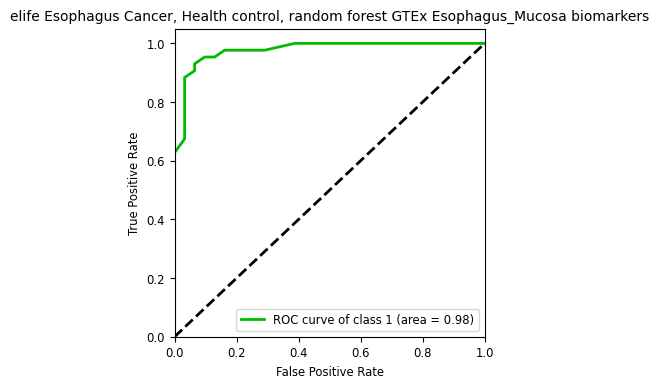

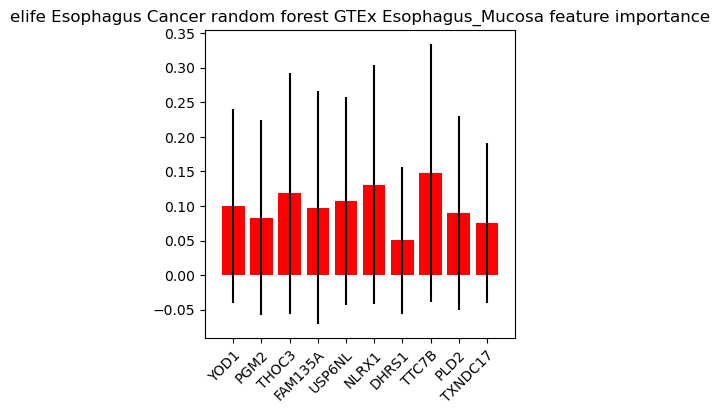

In [8]:
%%time
# mean AUC 0.0.6683
EsophagusMucosaDataDict = runAll( 
                        features=["Esophagus_Mucosa"],
                        selectElifeCategories=["Healthy donor", "Esophagus Cancer"],
                        setName='Esophagus_Mucosa',
                        cancerType="Esophagus"
                    )

In [9]:
# ############################################################
# runFeatureImportance(dataDict=EsophagusMucosaDataDict,
#                        setName='Esophagus_Mucosa',
#                         cancerType="Esophagus",
#                        useHUGOImportanceFeatureNames=True
#                       )

In [10]:
aedwip

NameError: name 'aedwip' is not defined

# <span style="background-color:yellow">Esophagus Cancer : Muscularis Biomarkers</span>

In [ ]:
%%time
# mean AUC 
EsophagusMuscularisDataDict = runAll( 
                        features=["Esophagus_Muscularis"],
                        selectElifeCategories=["Healthy donor", "Esophagus Cancer"],
                        setName='Esophagus_Muscularis',
                        cancerType="Esophagus"
                    )

# <span style="background-color:yellow">Esophagus Cancer : Gastroesophageal_Junction Biomarkers</span>

In [ ]:
%%time
# mean AUC 
EsophagusGastroesophageal_JunctionDataDict = runAll( 
                        features=["Esophagus_Gastroesophageal_Junction"],
                        selectElifeCategories=["Healthy donor", "Esophagus Cancer"],
                        setName='Esophagus_Gastroesophageal_Junction',
                        cancerType="Esophagus"
                    )

# <span style="background-color:yellow">Esophagus Cancer : ESCA Biomarkers</span>

In [ ]:
%%time
# mean AUC 
EsophagusESCADataDict = runAll( 
                        features=["ESCA"],
                        selectElifeCategories=["Healthy donor", "Esophagus Cancer"],
                        setName='Esophagus_ESCA',
                        cancerType="Esophagus"
                    )

# <span style="background-color:yellow">Lung Cancer</span>

In [ ]:
%%time
# aedavids@mustard $ head -n 2 `cat lung.csvs.txt ` | cut -d , -f 7
# ==> randomForestHyperparmeterAllSearch.sh.out/randomForestHyperparmeterSearch.csv <==
# auc_mean
# 0.7755952380952381

# ==> randomForestHyperparmeterLUADSearch.sh.out/randomForestHyperparmeterSearch.csv <==
# auc_mean
# 0.5968253968253968

# ==> randomForestHyperparmeterLung.sh.out/randomForestHyperparmeterSearch.csv <==
# auc_mean
# 0.7515873015873017

# ==> randomForestHyperparmeterLUSCSearch.sh.out/randomForestHyperparmeterSearch.csv <==
# auc_mean
# 0.5367063492063491

# Lung is probably better it uses fewer features
LungDataDict = runAll( 
                    features=["Lung"],
                    selectElifeCategories=["Healthy donor", "Lung Cancer"],
                    setName='Lung',
                    cancerType="Lung"
                )

# <span style="background-color:yellow">Liver Cancer</span>

In [ ]:
%%time
# mean AUC = 0.7831
liverDataDict = runAll( 
                    features=["Liver"],
                    selectElifeCategories=["Healthy donor", "Liver Cancer"],
                    setName='Liver',
                    cancerType="Liver"
                      )

# <span style="background-color:yellow">Stomach Cancer</span>

In [ ]:
%%time
# mean AUC = 0.8345
stomachDataDict = runAll( 
                        features=["Stomach"],
                        selectElifeCategories=["Healthy donor", "Stomach Cancer"],    
                        setName='Stomach',
                        cancerType="Stomach",
                    )

# <span style="background-color:yellow">Colorectal Cancer</span>

In [ ]:
%%time
logger.warning('randomForestHyperparmeterColon_SigmoidSearch.sh.log failed!!')

# mean AUC = 0.7845
colorectalDataDict = runAll( 
                            features=["COAD"],
                            selectElifeCategories=["Healthy donor", "Colorectal Cancer"],    
                            setName='COAD_',
                            cancerType="Colorectal",
                        ) 

In [ ]:
from sklearn.datasets import load_iris
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import plot_tree

# Load the Iris dataset
X, y = load_iris(return_X_y=True)
# print(f'type(X): {type(X)} X :\n{X}')
# print(f'type(y): {type(y)} y : \n{y}')

# Train a RandomForestClassifier
model = RandomForestClassifier(random_state=42, n_estimators=10)  # using 10 trees for simplicity
model.fit(X, y)

# Select one tree from the forest
tree_index = 0  # selecting the first tree
single_tree = model.estimators_[tree_index]

# Plot the selected tree
plt.figure(figsize=(20,10))
plot_tree(single_tree, filled=True, feature_names=['sepal length', 'sepal width', 'petal length', 'petal width'], class_names=['Setosa', 'Versicolor', 'Virginica'])
plt.title(f"Decision Tree {tree_index} from Random Forest")
plt.show()

In [ ]:
# try treeviz

### check are we labeling the xticks correctly?
default order=decending should produce identical plots if the feature names are in the same order as the X feature columns

In [ ]:
print(f' model.feature_importances_ : {model.feature_importances_}')

fNames = ['petal length', 'petal width','sepal length', 'sepal width']
print(f'fNames: {fNames}')
skplt.estimators.plot_feature_importances(
 model, feature_names=fNames,
    x_tick_rotation=45,
    order=None,
)

In [ ]:
skplt.estimators.plot_feature_importances(
 model, feature_names=fNames,
    x_tick_rotation=45,
    #order=None,
)

In [ ]:
print( f'{type(X)}  {type(y)}' )

In [ ]:
print(X.shape)
X[0:2, :]

In [ ]:
permutation = [3, 2, 1, 0] # reverse order
X2 = X[:,permutation]
print(X2.shape)
X2[0:2, :]

In [ ]:
# Train a RandomForestClassifier
model2 = RandomForestClassifier(random_state=42, n_estimators=10)  # using 10 trees for simplicity
model2.fit(X2, y)

print(f' model2.feature_importances_ : {model2.feature_importances_}')

rNames = fNames.copy()
rNames.reverse()
print(f'rnames : {rNames}')
skplt.estimators.plot_feature_importances(
 model2, feature_names=rNames,
    x_tick_rotation=45,
    order=None,
)

In [ ]:
skplt.estimators.plot_feature_importances(
 model2, feature_names=rNames,
    x_tick_rotation=45,
    #order=None,
)